# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 70000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative
#actualScore = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (70000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


Observation(s):

1. I found 70000 data points and 10 features in the dataset.
2. Here I have not taken into consideration those reviews with Score=3.Because it is nither positive or nagitive.
3. So it is better to remove 3 from consideration.

In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

Observation(s):

1. Here same ProfileName (Geetha Krishnan) has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text.
2. Which is not possible
3. So we will have to remove duplicates and keep only the 1st one.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

Observation(s):
     1. Here Sorting data according to ProductId in ascending order and getting a well menar data set

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(62864, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

89.80571428571429

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

Observation(s):

1. I have keep only those values whose HelpfulnessNumerator <= HelpfulnessDenominator.

In [13]:

#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(62862, 10)


1    52600
0    10262
Name: Score, dtype: int64

Observation(s):

1. After claening the dataset I found 62862 data points and 10 features in the dataset.
2. I found 52600 positive and 10262 negative reviews in our datase.
3. These all are after cleaning the dataset.

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_62861 = final['Text'].values[62861]
print(sent_62861)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
A truly wonderfull chutney from Southern Africa...Very nice on Currys, BBQ meats and Boerworse subs.
Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.<br />strongly recommend


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_62861 = re.sub(r"http\S+", "", sent_62861)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_62861, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
A truly wonderfull chutney from Southern Africa...Very nice on Currys, BBQ meats and Boerworse subs.
Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.strongly recommend


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_62861 = decontracted(sent_62861)
print(sent_62861)
print("="*50)

Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.<br />strongly recommend


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_62861 = re.sub('[^A-Za-z0-9]+', ' ', sent_62861)
print(sent_62861)

Purchased this product at a local store in NY and my kids and i love it Its a quick easy meal You can put in a toaster oven on toast for 6 min and its ready to eat br strongly recommend


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

Observation(s):

1. Here we are having set of stopwords.
2. Here so many unused word in the stopwords.
3. stopwords are words which contain a dictionary of unused words.
4. If we are removing stopwordsthen our Bag of Words is much smaller and meaningful vector.

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 62862/62862 [00:45<00:00, 1382.08it/s]


In [23]:
preprocessed_reviews[62861]

'purchased product local store ny kids love quick easy meal put toaster oven toast min ready eat strongly recommend'

In [24]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=preprocessed_reviews
final['CleanedText']=final['CleanedText']
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (62862, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,used victor fly bait seasons ca not beat great...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...


Observation(s):

1. Here processed review can be seen in the CleanedText Column.
2. We will use it for future observation.
3. we are having 62862 matrix of features.

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
# printing some random reviews
sent_0 = final['Summary'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Summary'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Summary'].values[1500]
print(sent_1500)
print("="*50)

sent_62861 = final['Summary'].values[62861]
print(sent_62861)
print("="*50)

Dog Lover Delites
Delightfully fruity
sprouts
DELICIOUS


In [26]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_62861 = re.sub(r"http\S+", "", sent_62861)

print(sent_0)

Dog Lover Delites


In [27]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_62861, 'lxml')
text = soup.get_text()
print(text)

Dog Lover Delites
Delightfully fruity
sprouts
DELICIOUS


In [28]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
sent_62861 = decontracted(sent_62861)
print(sent_62861)
print("="*50)

DELICIOUS


In [30]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Dog Lover Delites


In [31]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_62861 = re.sub('[^A-Za-z0-9]+', ' ', sent_62861)
print(sent_62861)

DELICIOUS


In [32]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [33]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_Summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 62862/62862 [00:32<00:00, 1941.42it/s]


In [34]:
preprocessed_Summary = [62861]
print (preprocessed_Summary)

[62861]


# Time Based Splitting

In [35]:
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Randomly selecting 20K datapoints

# We will collect different 20K rows without repetition from time_sorted_data dataframe
final_20 = time_sorted_data.take(np.random.permutation(len(final))[:20000])
print(final_20.shape)
final_20.head(3)

(20000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
34122,37127,B000P8HPCI,A26HSLN8W5UERB,Hannah Weldon,3,3,1,1325116800,Best Olive Ever,Recently had these at a holiday party and FINA...,recently holiday party finally found person of...
14387,15693,B0002ASQ8Q,A277ERJUOBNROA,"Jude ""lit hag""",0,0,1,1350518400,Good buy. Long lasting. Safe,I have a Lhasa Apso. She goes through bully st...,lhasa apso goes bully sticks day pop senior fi...
15885,17362,B000EVIDUY,A1K4KGJRRCY7MZ,Kathryn Ozan,0,0,1,1190592000,Pretty Good GF Substitution,These brownies are a pretty good substitution ...,brownies pretty good substitution regular brow...


Observation(s):
1. Time based splitting is better than random splitting.
2. In time based splitting we sort our data in ascending order.
3. In TIme based splitting we get better accuracy than random splitting.

In [36]:
# sample dataset 
final_20['Score'].value_counts()

1    16697
0     3303
Name: Score, dtype: int64

Observation(s):
    
1. Here I have taken 20K Data Points.
2. Because I have got memory error and my laptop got hang on 30K or 40K data points.
4. when I have converted sparse matrix to dense matrix with higher reviews (52600, 10262)

In [37]:
# Original dataset
final['Score'].value_counts()

1    52600
0    10262
Name: Score, dtype: int64

In [38]:
# Ratio of positive reviews to negative reviews in Sample Dataset
len(final_20[final_20['Score'] == 1])/len(final_20[final_20['Score'] == 0])

5.055101422948835

In [39]:
# Ratio of positive reviews to negative reviews in Original Dataset
len(final[final['Score'] == 1])/len(final[final['Score'] == 0])

5.12570648996297

In [40]:

# final_20 datapoints which will use to train model
X = final_20['CleanedText'].values
print("shape of X:", X.shape)

shape of X: (20000,)


In [41]:
# class label
y = final_20['Score'].values
print("shape of y:", y.shape)

shape of y: (20000,)


In [42]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# Splitting the data set into training set and test set:
from sklearn.model_selection import train_test_split

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_cv.shape, Y_cv.shape)

(10720,) (10720,) (4000,) (4000,) (5280,) (5280,)


Observation(s):
    
1. I have split the dataset into training set and testing set.
2. Here 80% of the data used to train the model and 20% of the data used to test its performance of the test set.
3. Here i have 16000 points to train the model and 4000 points to test its performance on the test set.

# [4] Featurization

## [4.1] BAG OF WORDS

In [43]:
#BoW
#https://www.kaggle.com/rochachan/part-1-for-beginners-bag-of-words
from sklearn.feature_extraction.text import CountVectorizer    #in scikit-learn
count_vect = CountVectorizer(min_df = 20, max_features=500).fit(X_train) # Here I am fitting my CountVectorizer function  into X_train and Then transform into X_train and X_test. 
# we also use fit_transform method for training set. I am doind it for auc
# min_df = 20;min_df = 20, which will remove any words from our vocabulary that appear in fewer than five documents.
# https://towardsdatascience.com/scikit-learn-for-text-analysis-of-amazon-fine-food-reviews-ea3b232c2c1b
X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_cv_bow.shape, Y_cv.shape)
print(X_test_bow.shape, Y_test.shape)
print("="*100)

print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
print("the type of count vectorizer :",type(X_train_bow))
print("the shape of out text BOW vectorizer : ",X_train_bow.get_shape())
print("the number of unique words :", X_train_bow.get_shape()[1])

After vectorizations
(10720, 500) (10720,)
(5280, 500) (5280,)
(4000, 500) (4000,)
some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almonds', 'almost', 'also']
the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (10720, 500)
the number of unique words : 500


## [4.2] Bi-Grams and n-Grams.

In [44]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=20, max_features=500).fit(X_train)
X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (10720, 500)
the number of unique words including both unigrams and bigrams  500


## [4.3] TF-IDF

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(min_df=50, max_features=500).fit(X_train)
X_train_tf_idf = tf_idf_vect.transform(X_train)
X_cv_tf_idf = tf_idf_vect.transform(X_cv)
X_test_tf_idf = tf_idf_vect.transform(X_test)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
print("the type of count vectorizer :",type(X_train_tf_idf))
print("the shape of out text TFIDF vectorizer : ",X_train_tf_idf.get_shape())
print("the number of unique words :", X_train_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almonds', 'almost', 'also']
the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (10720, 500)
the number of unique words : 500


In [46]:
print("the number of unique words :", X_test_tf_idf.get_shape()[1])

the number of unique words : 500


## [4.4] Word2Vec

## Preparing Reviews for gensim model

In [47]:
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

## Training w2v model

In [48]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

## Training w2v model

In [49]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [50]:
# Train our own Word2Vec model using our own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
print('='*70)

[('good', 0.8648442029953003), ('excellent', 0.8328536748886108), ('unbeatable', 0.7285969257354736), ('makes', 0.726311206817627), ('awesome', 0.7210606336593628), ('works', 0.7175104022026062), ('decent', 0.7102307677268982), ('amazing', 0.7019433975219727), ('quick', 0.696099579334259), ('overall', 0.6910626292228699)]
[('world', 0.9803078174591064), ('hands', 0.978015124797821), ('hooked', 0.975773274898529), ('popular', 0.9715628623962402), ('restaurant', 0.971121072769165), ('gummies', 0.9698094129562378), ('superior', 0.9696789979934692), ('possibly', 0.9693596959114075), ('varieties', 0.9684944748878479), ('boston', 0.9673042297363281)]


In [51]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  6350
sample words  ['allergic', 'corn', 'eating', 'marshmallows', 'candy', 'pecan', 'pie', 'etc', 'without', 'able', 'syrup', 'real', 'problem', 'golden', 'made', 'cane', 'sugar', 'used', 'substitute', 'not', 'taste', 'quite', 'though', 'good', 'think', 'one', 'calls', 'instance', 'satisfying', 'thing', 'instead', 'seems', 'little', 'sweeter', 'agree', 'majority', 'reviewers', 'stating', 'excellent', 'coffee', 'rich', 'overwhelming', 'caramel', 'flavor', 'familiar', 'brand', 'prior', 'finding', 'sale', 'know']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

## Algorithm: Avg W2V

#### [4.4.1.1] Avg W2v

In [52]:
from tqdm import tqdm
import numpy as np

### Converting Train data text

In [53]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 10720/10720 [00:20<00:00, 511.21it/s]


(10720, 50)
[-0.50567656  0.36436939  0.40456252 -0.11615256  0.36491861 -0.0012507
  0.57495818 -0.67580355  0.06119272 -0.05797765  0.14908494  0.37967587
  0.12141232 -0.16254363  0.39997208 -0.09095222 -0.44017627 -0.11542203
  0.06091902 -0.63028051  0.28038448  0.23529822 -0.79160718 -0.19916295
 -0.45477575 -0.69283093  0.25292877  0.76171322 -0.37227927  0.17009451
 -0.64616299 -0.03046318  0.32565779 -0.32116698  0.01224741  0.44531192
 -0.4075686  -0.66918487  0.68692049 -0.46377833 -0.15619949  0.13778466
  0.11063297 -0.14448946 -0.62233791  0.37940836  0.22136578  0.94912649
 -0.12328865 -0.49539188]


### Converting CV data text

In [54]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [55]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|█████████████████████████████████████████████████████████████████████████████| 5280/5280 [00:10<00:00, 525.49it/s]

(5280, 50)
[-0.23864938  0.11537472 -0.10630998 -0.02752185  0.31668659 -0.13778031
  0.30637822 -0.46593953  0.00906736  0.21212043  0.406048    0.82526463
  0.26720251 -0.2343858   0.74478695 -0.1672709  -0.44122969  0.09876661
 -0.029525   -0.65720965  0.36943401  0.4553213  -0.56945411 -0.20007028
 -0.36004852 -0.24835145  0.34894036  0.82758311 -0.40415143  0.12438912
 -0.42506224 -0.20182169  0.18474679 -0.26759961 -0.13618364  0.12179685
 -0.26440106 -0.57265148  0.54115969  0.37501272  0.02949713  0.1118158
 -0.4223703  -0.1171917  -0.61743374  0.4731367   0.16248513  0.55449299
 -0.39493371 -0.42123115]


### Converting Test data text

In [56]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [57]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 494.45it/s]

(4000, 50)
[-5.87772756e-02  4.18595533e-01  5.83847408e-02 -4.75243009e-02
  5.79367020e-01  2.08227085e-02  4.51402813e-02 -4.77560367e-02
 -3.60087212e-01  1.32365348e-01  1.22112405e-01  8.72838671e-01
  2.45847812e-01  3.27602737e-01  4.38771939e-01 -8.31729712e-02
 -1.82892016e-01  6.49681873e-01  3.62163127e-01 -6.83701419e-02
  5.18596292e-01  4.65779694e-01 -3.74255917e-01 -2.12528573e-01
 -1.77639744e-04 -8.38465974e-01 -5.72662271e-02  9.05012891e-01
 -2.03504324e-01  1.85017944e-01 -4.91719771e-01 -1.85564356e-01
  2.64701002e-01  1.16778000e-02  1.75145305e-01  6.22935615e-01
 -8.74881043e-01 -8.20322936e-01  5.27980831e-01  3.18523273e-01
  5.02352461e-02  1.66326368e-01 -9.89469315e-01 -8.49913777e-02
 -4.01778819e-01  7.90802389e-02 -2.46812065e-01  1.66605937e-01
 -3.25752531e-01 -5.07073159e-01]


#### [4.4.1.2] TFIDF weighted W2v

In [58]:
from tqdm import tqdm
import numpy as np

In [59]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

### Converting Train data text

In [60]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_fealist_of_sentance_traint.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

100%|████████████████████████████████████████████████████████████████████████████| 10720/10720 [08:50<00:00, 20.19it/s]

(10720, 50)
[-0.58069521  0.46572438  0.60610273 -0.10217385  0.28991045  0.05490741
  0.68055113 -0.80401119  0.11357495 -0.17474928  0.02089311  0.10066545
  0.06111475 -0.1569596   0.31407193 -0.14470629 -0.35282022 -0.2268104
  0.13003731 -0.59022016  0.33380909  0.11437893 -0.91091427 -0.1219711
 -0.55691343 -0.93473767  0.25110382  0.78064269 -0.23614184  0.19479455
 -0.76528645  0.09921084  0.40548166 -0.47827371  0.02522382  0.58480078
 -0.50952781 -0.68137529  0.7775031  -0.86180987 -0.21435514  0.10311287
  0.41065295 -0.19188379 -0.6271985   0.34772755  0.34921952  1.16379774
  0.13140638 -0.56798726]


In [61]:
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

10720
50


### Converting CV data text

In [62]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [63]:
tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_fealist_of_sentance_traint.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])

100%|██████████████████████████████████████████████████████████████████████████████| 5280/5280 [04:18<00:00, 20.44it/s]

(5280, 50)
[-0.2914667   0.06740021 -0.17576593  0.03419138  0.2410993  -0.22587734
  0.2276356  -0.52673073  0.04053038  0.18638494  0.45651024  0.81895497
  0.36573843 -0.37716031  0.81941529 -0.23658892 -0.34703748 -0.01583319
 -0.10660468 -0.6924534   0.45425266  0.45980606 -0.65855498 -0.06224454
 -0.35092918 -0.17688733  0.40544231  0.89060588 -0.37396237  0.11400144
 -0.45650254 -0.19399738  0.16271532 -0.33518971 -0.29343289  0.0270679
 -0.36239792 -0.5480135   0.59705591  0.35595082  0.08783469  0.15143359
 -0.39417527 -0.12807353 -0.62809879  0.58310781  0.23669239  0.66128471
 -0.29064521 -0.43536874]


### Converting Test data text

In [64]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [65]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_fealist_of_sentance_traint.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [03:22<00:00, 19.75it/s]

(4000, 50)
[-0.08816207  0.33659502  0.00899858 -0.00534065  0.53030319 -0.07881527
  0.0636143  -0.07200521 -0.35293134  0.09905596  0.15536967  0.82323564
  0.2831109   0.2292855   0.43151038 -0.10840765 -0.13786086  0.56920969
  0.25170216 -0.12340427  0.5025805   0.37224289 -0.34069539 -0.11842558
 -0.00505096 -0.72243106  0.00286075  0.83176882 -0.2146745   0.1744087
 -0.4517673  -0.18947454  0.22109973  0.00500266  0.10680415  0.51522025
 -0.82267658 -0.74908211  0.49816542  0.27849976  0.08107011  0.16954624
 -0.88310025 -0.03836889 -0.35697079  0.15065507 -0.19704844  0.19272627
 -0.24984871 -0.52751578]


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [66]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/
# 10 Fold Cross-Validation (Brute force implementation)
# Use KNN to predict whether Review is positive or Negative.
# Importing libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# creating odd list of K for KNN
myList = list(range(0,20))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_cv_bow, Y_cv, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())

# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 17.


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

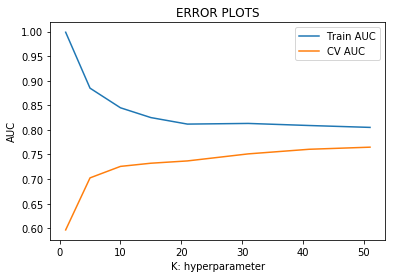

In [67]:
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_bow, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  knn.predict_proba(X_train_bow)[:,1]
    Y_cv_pred =  knn.predict_proba(X_cv_bow)[:,1]
    # https://discuss.analyticsvidhya.com/t/what-is-the-difference-between-predict-and-predict-proba/67376
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

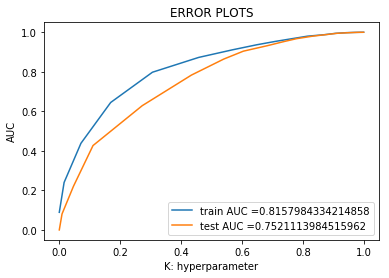

Train confusion matrix
[[ 414 1357]
 [ 288 8661]]
Test confusion matrix
[[ 147  521]
 [ 108 3224]]
Test AUC is: 0.7521113984515962


In [68]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


knn = KNeighborsClassifier(n_neighbors=19) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
knn.fit(X_train_bow, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, knn.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, knn.predict(X_test_bow)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
bow_brute_auc = roc_auc_score(Y_test, knn.predict_proba(X_test_bow)[:,1])
print("Test AUC is:", bow_brute_auc)

In [69]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')

# fitting the model
knn_optimal.fit(X_train_bow, Y_train)

# predict the response
Y_pred = knn_optimal.predict(X_test_bow)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %0.3f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_brute_K = optimal_k
bow_brute_train_acc = max(cv_scores)*100
bow_brute_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 17 is 84.350%


Observation(s):
    
1. The Test Accuracy of the K-NN classifier for k = 19 is 83.150%.

Observation(s):

1. Here is a confusion matrix.
1. As we have seen on confusion matrix, we have 3191 + 135 = 3326 correct prediction on test set.
2. Acccuracy of 3326 correct prediction on test set is 83.150%.

In [70]:
# Some Additional Reference:

# https://www.ritchieng.com/machine-learning-evaluate-classification-model/
# https://stackoverflow.com/questions/31138751/roc-curve-from-training-data-in-caret

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [71]:
# Applying KNN brute force on TFIDF

# creating odd list of K for KNN
myList = list(range(0,20))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_cv_tf_idf, Y_cv, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 15.


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

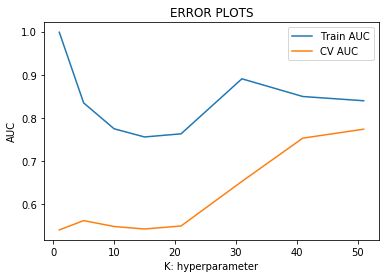

In [72]:
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_tf_idf, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  knn.predict_proba(X_train_tf_idf)[:,1]
    Y_cv_pred =  knn.predict_proba(X_cv_tf_idf)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

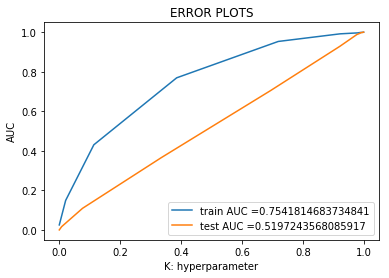

Train confusion matrix
[[  14 1757]
 [   7 8942]]
Test confusion matrix
[[   3  665]
 [   5 3327]]
AUC is: 0.5197243568085917


In [73]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train_tf_idf, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn.predict_proba(X_train_tf_idf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn.predict_proba(X_test_tf_idf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, knn.predict(X_train_tf_idf)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, knn.predict(X_test_tf_idf)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
tf_idf_brute_auc = roc_auc_score(Y_test, knn.predict_proba(X_test_tf_idf)[:,1])
print("AUC is:", tf_idf_brute_auc)

In [74]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')

# fitting the model
knn_optimal.fit(X_train_tf_idf, Y_train)

# predict the response
Y_pred = knn_optimal.predict(X_test_tf_idf)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %0.3f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_brute_K = optimal_k
tfidf_brute_train_acc = max(cv_scores)*100
tfidf_brute_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 15 is 83.225%


Observation(s):
    
1. The Test Accuracy of the K-NN classifier for k = 17 is 82.875%.

Observation(s):
    
1. Here is a confusion matrix.
1. As we have seen on confusion matrix, we have 3314 + 1 = 3315 correct prediction on test set.
2. Acccuracy of 3315 correct prediction on test set is 82.875%.

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [75]:
# Applying KNN brute force on AVG W2V

# creating odd list of K for KNN
myList = list(range(0,20))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, sent_vectors_cv, Y_cv, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 19.


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

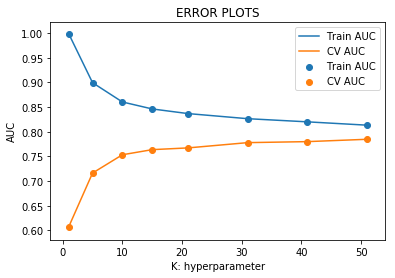

In [76]:
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  knn.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred =  knn.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

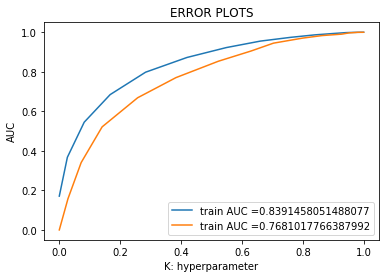

Train confusion matrix
[[ 284 1487]
 [ 119 8830]]
Test confusion matrix
[[  91  577]
 [  56 3276]]
AUC is: 0.7681017766387992


In [77]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(sent_vectors_train, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, knn.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, knn.predict(sent_vectors_test)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
Avg_Word2Vec_brute_auc = roc_auc_score(Y_test,knn.predict_proba(sent_vectors_test)[:,1])
print("AUC is:", Avg_Word2Vec_brute_auc)

In [78]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute', n_jobs=-1)

# fitting the model
knn_optimal.fit(sent_vectors_train, Y_train)

# predict the response
Y_pred = knn_optimal.predict(sent_vectors_test)

# evaluate accuracy
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %0.3f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
Avg_Word2Vec_brute_K = optimal_k
Avg_Word2Vec_brute_train_acc = max(cv_scores)*100
Avg_word2Vec_brute_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 19 is 84.175%


Observation(s):
    
1. The Test Accuracy of the K-NN classifier for k = 19 is 83.600%.

Observation(s):
    
1. Here is a confusion matrix.
1. As we have seen on confusion matrix, we have 3282 + 62 = 3444 correct prediction on test set.
2. Acccuracy of 3444 correct prediction on test set is 83.600%.

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [79]:
# 10 Fold Cross-Validation (Brute force implementation)

# creating odd list of K for KNN
myList = list(range(0,20))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, tfidf_sent_vectors_cv, Y_cv, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 19.


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

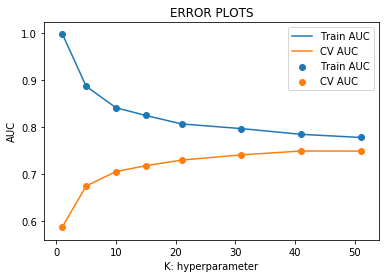

In [80]:
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(tfidf_sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  knn.predict_proba(tfidf_sent_vectors_train)[:,1]
    Y_cv_pred =  knn.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

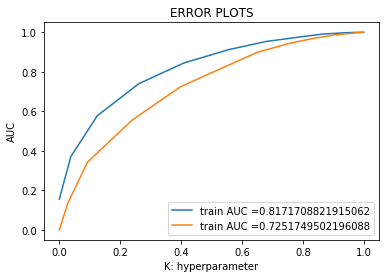

Train confusion matrix
[[ 240 1531]
 [  84 8865]]
Test confusion matrix
[[  63  605]
 [  45 3287]]
Test AUC is: 0.7251749502196088


In [81]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(tfidf_sent_vectors_train, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, knn.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, knn.predict(tfidf_sent_vectors_test)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
TFIDF_Word2Vec_brute_auc = roc_auc_score(Y_test,knn.predict_proba(tfidf_sent_vectors_test)[:,1])
print("Test AUC is:", TFIDF_Word2Vec_brute_auc)

In [82]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute', n_jobs=-1)

# fitting the model
knn_optimal.fit(tfidf_sent_vectors_train, Y_train)

# predict the response
Y_pred = knn_optimal.predict(tfidf_sent_vectors_test)

# evaluate accuracy
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %0.3f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
TFIDF_Word2Vec_brute_K = optimal_k
TFIDF_Word2Vec_brute_train_acc = max(cv_scores)*100
TFIDF_word2Vec_brute_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 19 is 83.650%


Observation(s):
    
1. The Test Accuracy of the K-NN classifier for k = 17 is 83.400%.

Observation(s):
    
1. Here is a confusion matrix.
1. As we have seen on confusion matrix, we have 3290 + 46 = 3336 correct prediction on test set.
2. Acccuracy of 3336 correct prediction on test set is 83.400%.

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [83]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100) #Desired dimensionality of output data. Must be strictly less than the number of features. 
                                     #The default value is useful for visualisation. For LSA, a value of 100 is recommended.
X_train_bow_dense = svd.fit_transform(X_train_bow)
X_cv_bow_dense = svd.transform(X_cv_bow)
X_test_bow_dense = svd.transform(X_test_bow)


# creating odd list of K for KNN
myList = list(range(0,20))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# https://machinelearningmastery.com/k-fold-cross-validation/
# https://scikit-learn.org/stable/modules/cross_validation.html
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, X_cv_bow, Y_cv, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 17.


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

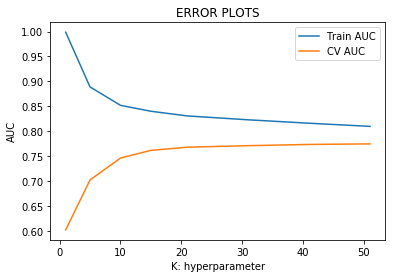

In [84]:
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_bow_dense, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  knn.predict_proba(X_train_bow_dense)[:,1]
    Y_cv_pred =  knn.predict_proba(X_cv_bow_dense)[:,1]
    # https://discuss.analyticsvidhya.com/t/what-is-the-difference-between-predict-and-predict-proba/67376
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

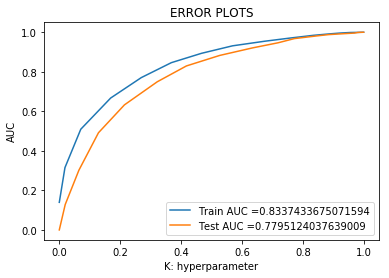

Train confusion matrix
[[ 424 1347]
 [ 259 8690]]
Test confusion matrix
[[ 152  516]
 [ 107 3225]]
Test AUC is: 0.7795124037639009


In [85]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train_bow_dense, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn.predict_proba(X_train_bow_dense)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn.predict_proba(X_test_bow_dense)[:,1])

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, knn.predict(X_train_bow_dense)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, knn.predict(X_test_bow_dense)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
bow_kdTree_acc = roc_auc_score(Y_test,knn.predict_proba(X_test_bow_dense)[:,1])
print("Test AUC is:", bow_kdTree_acc)

In [86]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree', n_jobs=-1)

# fitting the model
knn_optimal.fit(X_train_bow_dense, Y_train)

# predict the response
Y_pred = knn_optimal.predict(X_test_bow_dense)

# evaluate accuracy
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %0.3f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_kdTree_K = optimal_k
bow_kdTree_train_acc = max(cv_scores)*100
bow_kdTree_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 17 is 84.250%


Observation(s):
    
1. The Test Accuracy of the K-NN classifier for k = 19 is 83.750%.

Observation(s):
    
1. Here is a confusion matrix.
1. As we have seen on confusion matrix, we have 3182 + 168 = 3350 correct prediction on test set.
2. Acccuracy of 3350 correct prediction on test set is 83.750%.

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [87]:
svd = TruncatedSVD(n_components=100)
X_train_tf_idf_dense = svd.fit_transform(X_train_tf_idf)
X_test_tf_idf_dense = svd.transform(X_test_tf_idf)
X_cv_tf_idf_dense = svd.transform(X_cv_tf_idf)

# creating odd list of K for KNN
myList = list(range(0,20))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, X_cv_tf_idf_dense, Y_cv, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 17.


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

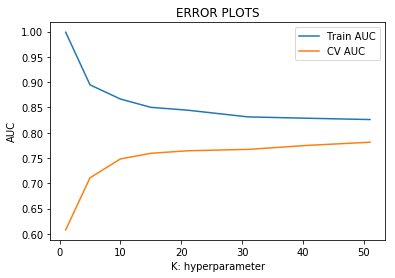

In [88]:
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_tf_idf_dense, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  knn.predict_proba(X_train_tf_idf_dense)[:,1]
    Y_cv_pred =  knn.predict_proba(X_cv_tf_idf_dense)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

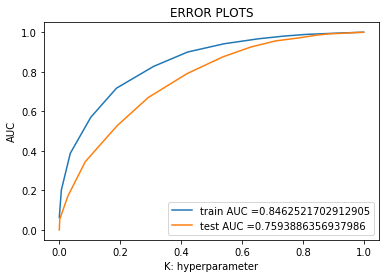

Train confusion matrix
[[ 464 1307]
 [ 174 8775]]
Test confusion matrix
[[ 143  525]
 [  96 3236]]
Test AUC is: 0.7593886356937986


In [89]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train_tf_idf_dense, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn.predict_proba(X_train_tf_idf_dense)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn.predict_proba(X_test_tf_idf_dense)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, knn.predict(X_train_tf_idf_dense)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, knn.predict(X_test_tf_idf_dense)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
tfidf_kdTree_auc = roc_auc_score(Y_test,knn.predict_proba(X_test_tf_idf_dense)[:,1])
print("Test AUC is:", tfidf_kdTree_auc)

In [90]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree', n_jobs=-1)

# fitting the model
knn_optimal.fit(X_train_tf_idf_dense, Y_train)

# predict the response
Y_pred = knn_optimal.predict(X_test_tf_idf_dense)

# evaluate accuracy
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %0.3f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_kdTree_K = optimal_k
tfidf_kdTree_train_acc = max(cv_scores)*100
tfidf_kdTree_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 17 is 84.550%


Observation(s):
    
1. The Test Accuracy of the K-NN classifier for k = 19 is 84.450%.

Observation(s):
    
1. Here is a confusion matrix.
1. As we have seen on confusion matrix, we have 3268 + 110 = 3378 correct prediction on test set.
2. Acccuracy of 3415 correct prediction on test set is 85.375%.

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [91]:
# creating odd list of K for KNN
myList = list(range(0,20))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, sent_vectors_cv, Y_cv, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 19.


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

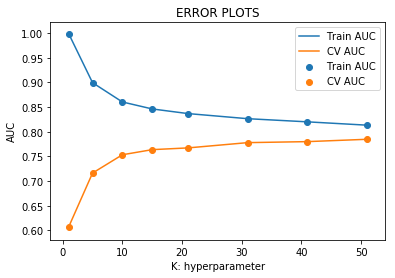

In [92]:
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  knn.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred =  knn.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

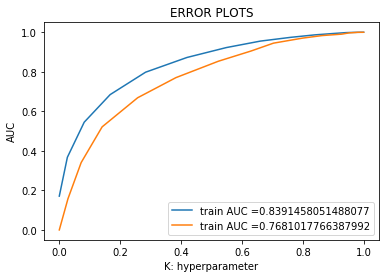

Train confusion matrix
[[ 284 1487]
 [ 119 8830]]
Test confusion matrix
[[  91  577]
 [  56 3276]]
Test AUC is: 0.7681017766387992


In [93]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(sent_vectors_train, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, knn.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, knn.predict(sent_vectors_test)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
Avg_Word2Vec_kdTree_auc = roc_auc_score(Y_test,knn.predict_proba(sent_vectors_test)[:,1])
print("Test AUC is:", Avg_Word2Vec_kdTree_auc)

In [94]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree', n_jobs=-1)

# fitting the model
knn_optimal.fit(sent_vectors_train, Y_train)

# predict the response
y_pred = knn_optimal.predict(sent_vectors_test)

# evaluate accuracy
acc = accuracy_score(Y_test, y_pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %0.3f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
Avg_Word2Vec_kdTree_K = optimal_k
Avg_Word2Vec_kdTree_train_acc = max(cv_scores)*100
Avg_Word2Vec_kdTree_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 19 is 84.175%


Observation(s):
    
1. The Test Accuracy of the K-NN classifier for k = 19 is 83.600%.

Observation(s):
    
1. Here is a confusion matrix.
1. As we have seen on confusion matrix, we have 3282 + 62 = 3344 correct prediction on test set.
2. Acccuracy of 3344 correct prediction on test set is 83.600%.

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [95]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, tfidf_sent_vectors_cv, Y_cv, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 29.


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

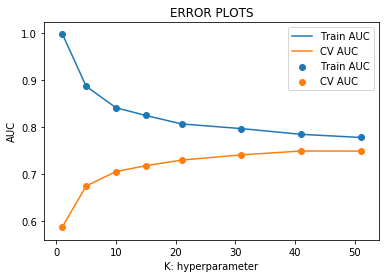

In [96]:
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(tfidf_sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  knn.predict_proba(tfidf_sent_vectors_train)[:,1]
    Y_cv_pred =  knn.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

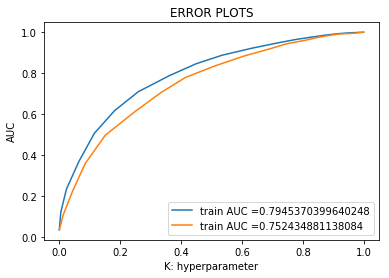

Train confusion matrix
[[ 113 1658]
 [  42 8907]]
Test confusion matrix
[[  32  636]
 [  21 3311]]
Test AUC is: 0.752434881138084


In [97]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

knn = KNeighborsClassifier(n_neighbors=33)
knn.fit(tfidf_sent_vectors_train, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, knn.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, knn.predict(tfidf_sent_vectors_test)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
TFIDF_Word2Vec_kdTree_auc = roc_auc_score(Y_test,knn.predict_proba(tfidf_sent_vectors_test)[:,1])
print("Test AUC is:", TFIDF_Word2Vec_kdTree_auc)

In [98]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree', n_jobs=-1)

# fitting the model
knn_optimal.fit(tfidf_sent_vectors_train, Y_train)

# predict the response
Y_pred = knn_optimal.predict(tfidf_sent_vectors_test)

# evaluate accuracy
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %0.3f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
TFIDF_Word2Vec_kdTree_K = optimal_k
TFIDF_Word2Vec_kdTree_train_acc = max(cv_scores)*100
TFIDF_Word2Vec_kdTree_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 29 is 83.675%


Observation(s):
    
1. Here is a confusion matrix.
1. As we have seen on confusion matrix, we have 2718 + 213 = 2931 correct prediction on test set.
2. Acccuracy of 2931 correct prediction on test set is 73.275%.

# [6] Conclusions

In [100]:
# 1. Table (Model Performances with their hyperparameters):
# pip install PrettyTable
# Creating table using PrettyTable library
from prettytable import PrettyTable

Features = ["BOW", "TFIDF", "W2V", "TFIDFW2V", "BOW", "TFIDF", "W2V", "TFIDFW2V"]

names = ["Brute", "Brute", "Brute", "Brute", "kdTree", "kdTree", "kdTree", "kdTree"]

optimal_K = [bow_brute_K, tfidf_brute_K, Avg_Word2Vec_brute_K, TFIDF_Word2Vec_brute_K, \
             bow_kdTree_K, tfidf_kdTree_K, Avg_Word2Vec_kdTree_K, TFIDF_Word2Vec_kdTree_K]

AUC = [bow_brute_auc, tf_idf_brute_auc, Avg_Word2Vec_brute_auc, TFIDF_Word2Vec_brute_auc, \
       bow_kdTree_acc, tfidf_kdTree_auc, Avg_Word2Vec_kdTree_auc, TFIDF_Word2Vec_kdTree_auc]

numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("Vectorizer",Features)
ptable.add_column("MODEL",names)
ptable.add_column("Hyper Parameer",optimal_K)
ptable.add_column("AUC",AUC)

# Printing the Table
print(ptable)

+-------+------------+--------+----------------+--------------------+
| S.NO. | Vectorizer | MODEL  | Hyper Parameer |        AUC         |
+-------+------------+--------+----------------+--------------------+
|   1   |    BOW     | Brute  |       17       | 0.7521113984515962 |
|   2   |   TFIDF    | Brute  |       15       | 0.5197243568085917 |
|   3   |    W2V     | Brute  |       19       | 0.7681017766387992 |
|   4   |  TFIDFW2V  | Brute  |       19       | 0.7251749502196088 |
|   5   |    BOW     | kdTree |       17       | 0.7795124037639009 |
|   6   |   TFIDF    | kdTree |       17       | 0.7593886356937986 |
|   7   |    W2V     | kdTree |       19       | 0.7681017766387992 |
|   8   |  TFIDFW2V  | kdTree |       29       | 0.752434881138084  |
+-------+------------+--------+----------------+--------------------+
